In [1]:
!python --version

Python 3.10.6


In [2]:
!nvidia-smi

Fri Jul 14 00:19:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     Off | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8              11W / 125W |    722MiB /  6144MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# !pip install \
# autodistill \
# autodistill-grounded-sam \
# autodistill-yolov8 \
# supervision

### Display images

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/home/darth/MLAI-projects/yolo_conveyor/yolo_conveyor_belt


In [5]:
VIDEO_DIR_PATH = f"{HOME}/videos"
# IMAGE_DIR_PATH = f"{HOME}/images_resized"
IMAGE_DIR_PATH = f"{HOME}/images"

FRAME_STRIDE = 10

In [6]:

import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH, 
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 50


In [7]:
# IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

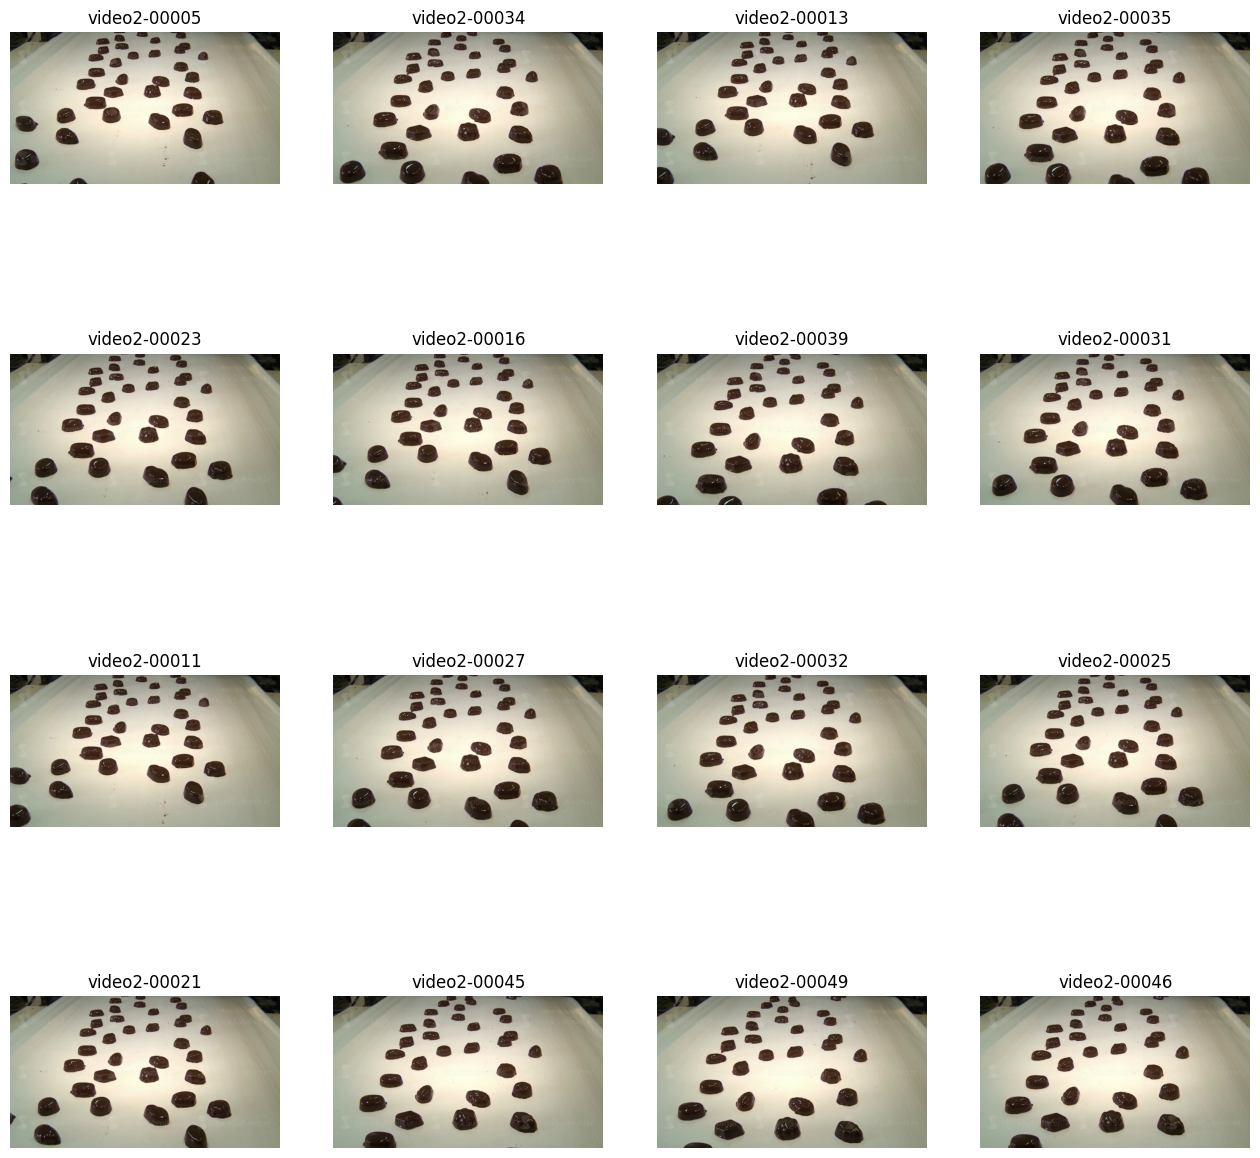

In [8]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

### Autolabel

In [9]:
# pip3 install autodistill-grounding-dino

In [11]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "brown chocolate": "chocolate"
})

In [12]:
DATASET_DIR_PATH = f"{HOME}/dataset"

In [13]:
IMAGE_DIR_PATH

'/home/darth/MLAI-projects/yolo_conveyor/yolo_conveyor_belt/images'

In [14]:
from autodistill_grounding_dino import GroundingDINO

base_model = GroundingDINO(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH, 
    extension=".png", 
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly


/home/darth/MLAI-projects/yolo_conveyor/envyolo/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Labeling /home/darth/MLAI-projects/yolo_conveyor/yolo_conveyor_belt/images/video2-00005.png:   0%|          | 0/50 [00:00<?, ?it/s]/home/darth/MLAI-projects/yolo_conveyor/envyolo/lib/python

Labeled dataset created - ready for distillation.


# Display annotated data

In [15]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [16]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH, 
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH, 
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

40

In [22]:
SAMPLE_SIZE = 50
SAMPLE_GRID_SIZE = (10, 5)
SAMPLE_PLOT_SIZE = (64, 32)

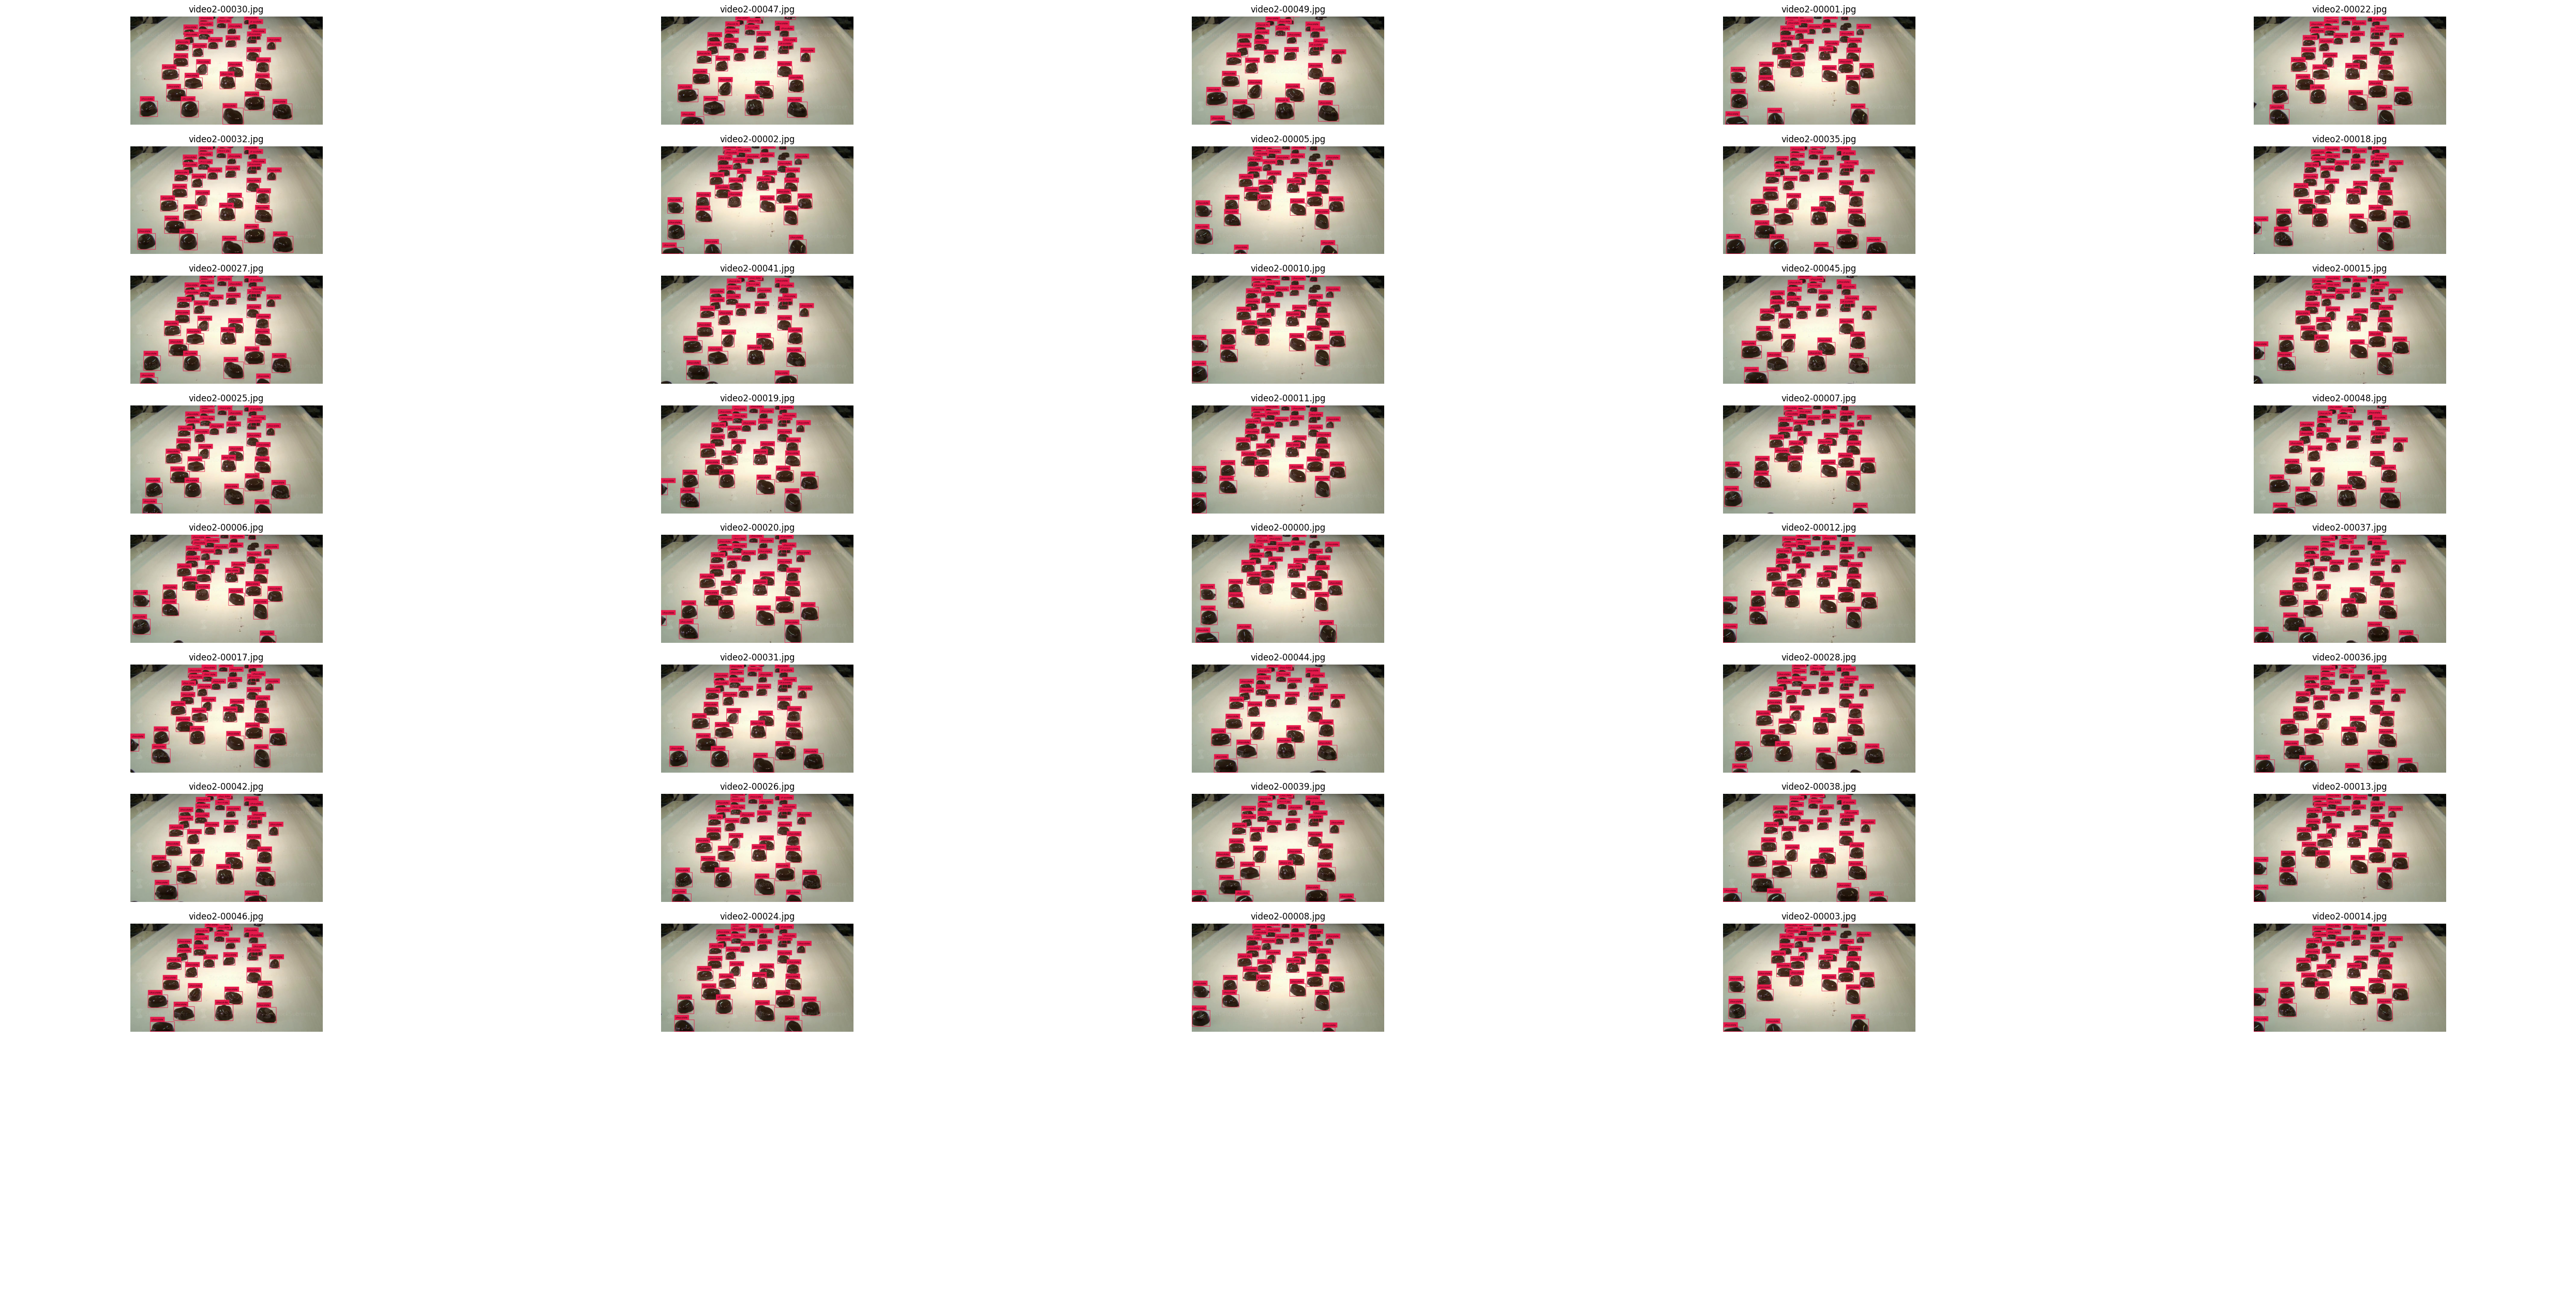

In [23]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(), 
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image, 
        detections=annotations, 
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images, 
    titles=image_names, 
    grid_size=SAMPLE_GRID_SIZE, 
    size=SAMPLE_PLOT_SIZE)